In [110]:
%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

pd.options.display.max_colwidth = 100

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot, offline
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

import requests

from os import listdir
import unicodedata

import json

from paths import *
from tools.vizu import remove_acentos
from tools.vizu import normalize_cols
from tools.io import read_sheets


from datetime import datetime
today = datetime.today().strftime('%Y-%m-%d')


# Import Data

In [111]:
# df = pd.read_csv('https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-states.csv')
# df['state'] = df['state'].str.replace('TOTAL','BRASIL')
# df.to_csv('brasil_states.csv', index=False)

# Brasil.IO

In [112]:
####### IMPORT DATA ######
url = 'https://brasil.io/api/dataset/covid19/caso/data?format=json'
df_final = pd.DataFrame()

while url != None:
    
    print(url)
    response = requests.get(url)
    data = response.text
    parsed = json.loads(data)
    url = parsed['next']
    df = pd.DataFrame(parsed['results']).sort_values(by='confirmed',ascending=False)
    df_final = pd.concat([df_final,df], axis=0)

https://brasil.io/api/dataset/covid19/caso/data?format=json
https://brasil.io/api/dataset/covid19/caso/data?format=json&page=2


## transformation

In [115]:
from tools.manipulation import create_br_not_sp

df = df_final.sort_values(by='confirmed',ascending=False)
dd = create_br_not_sp(df)

### GET ONLY LAST DAY
mask = dd['date'] < today
dd = dd[mask]

dd = dd.sort_values(by=['date'],ascending=False)
dd = dd.sort_values(by=['confirmed'],ascending=False)

# get only the states
mask = ((dd['place_type']!='city'))
df_states = dd[mask]
df_states = df_states.sort_values(by=['date'],ascending=False)

## MYTABLE

In [117]:
from tools.io import read_sheets
df = read_sheets('covid19_estados')

In [130]:
for col in ['confirmed','new_cases','deaths','new_cases']:
    df[col] = pd.to_numeric(df[col])

In [137]:
df_states = df.sort_values(by=['date','confirmed'], ascending=False)
df_states['city'] = df_states['state']
df_states.head()

,date,state,confirmed,new_cases,deaths,new_deaths,city
371,2020-03-25,BRASIL,2433,160,57,11,BRASIL
363,2020-03-25,SP,862,52,48,8,SP
362,2020-03-25,RJ,370,65,6,0,RJ
353,2020-03-25,CE,200,15,0,0,CE
364,2020-03-25,DF,177,0,0,0,DF


## VIS

In [140]:
from tools.vizu import brasil_vis
df_states = df_states.sort_values(by=['date'],ascending=False)

escala  = 'lin'
largura = None
save    = True
#### CHOSE CITIES TO START SELECTED IN GRAPH
in_cities = ['BRASIL','SP', 'RJ']

# mask = ((dd[var_col]>0))
# dd = dd[mask]

## confirmed or deaths
for var in ['deaths','confirmed']:
    fig = brasil_vis(df_states, var,in_cities, escala, today='25/03/2020', save=True)

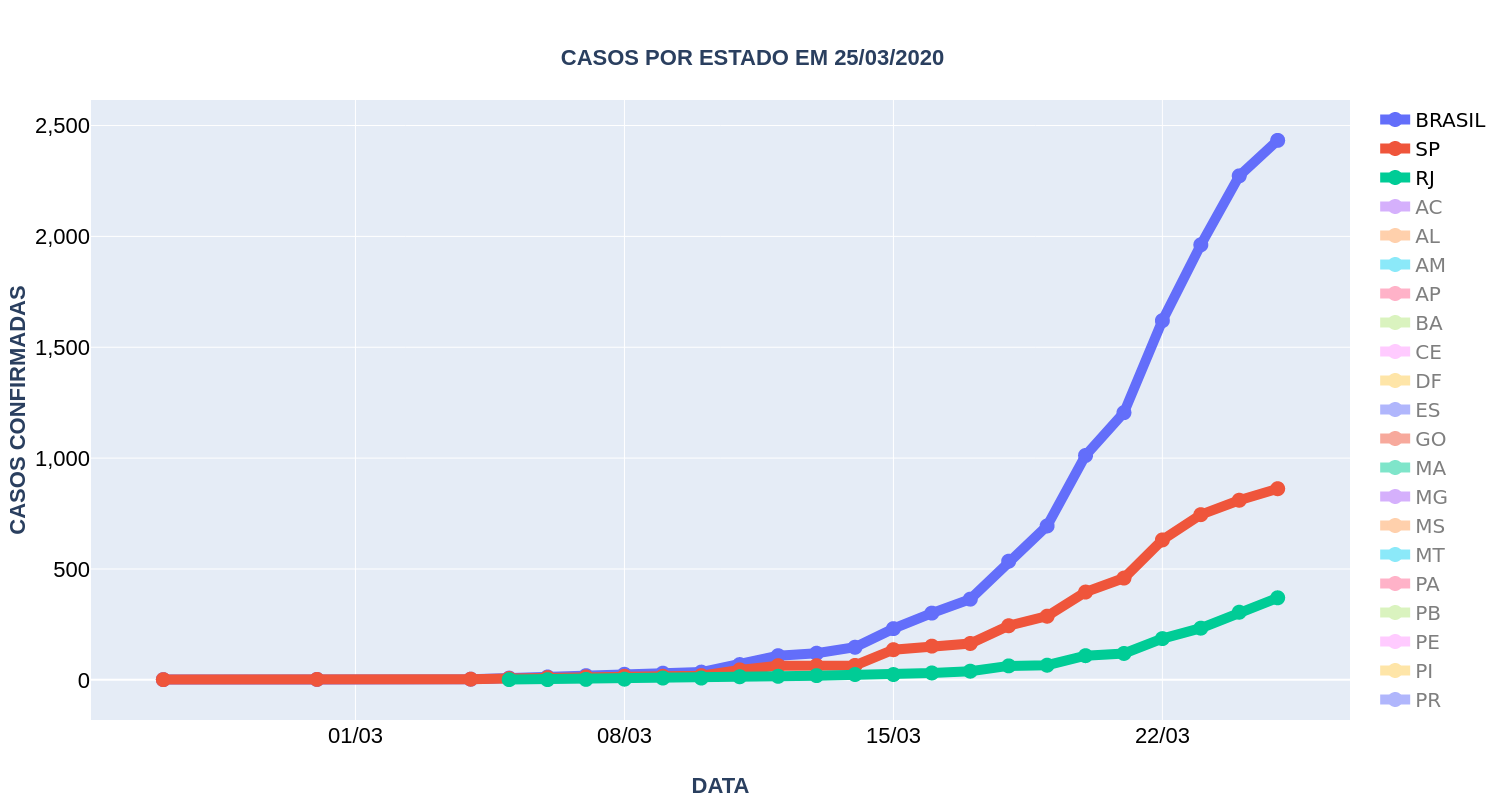

In [141]:
fig